<a href="https://colab.research.google.com/github/Tasfia-007/The-Wiser-Project/blob/main/The_Wiser_Exponential_Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


# Step 1: Run this cell first to install all necessary packages.
# After this finishes, you MUST restart the runtime.
# Go to the menu: Runtime -> Restart session
!pip install -q qiskit qiskit-aer matplotlib pylatexenc
!pip install qiskit-ibm-runtime
print("✅ All packages installed successfully. Please restart the runtime now.")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.2/366.2 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninsta


--- Generating Circuit Diagram for 4-Layer QGB ---


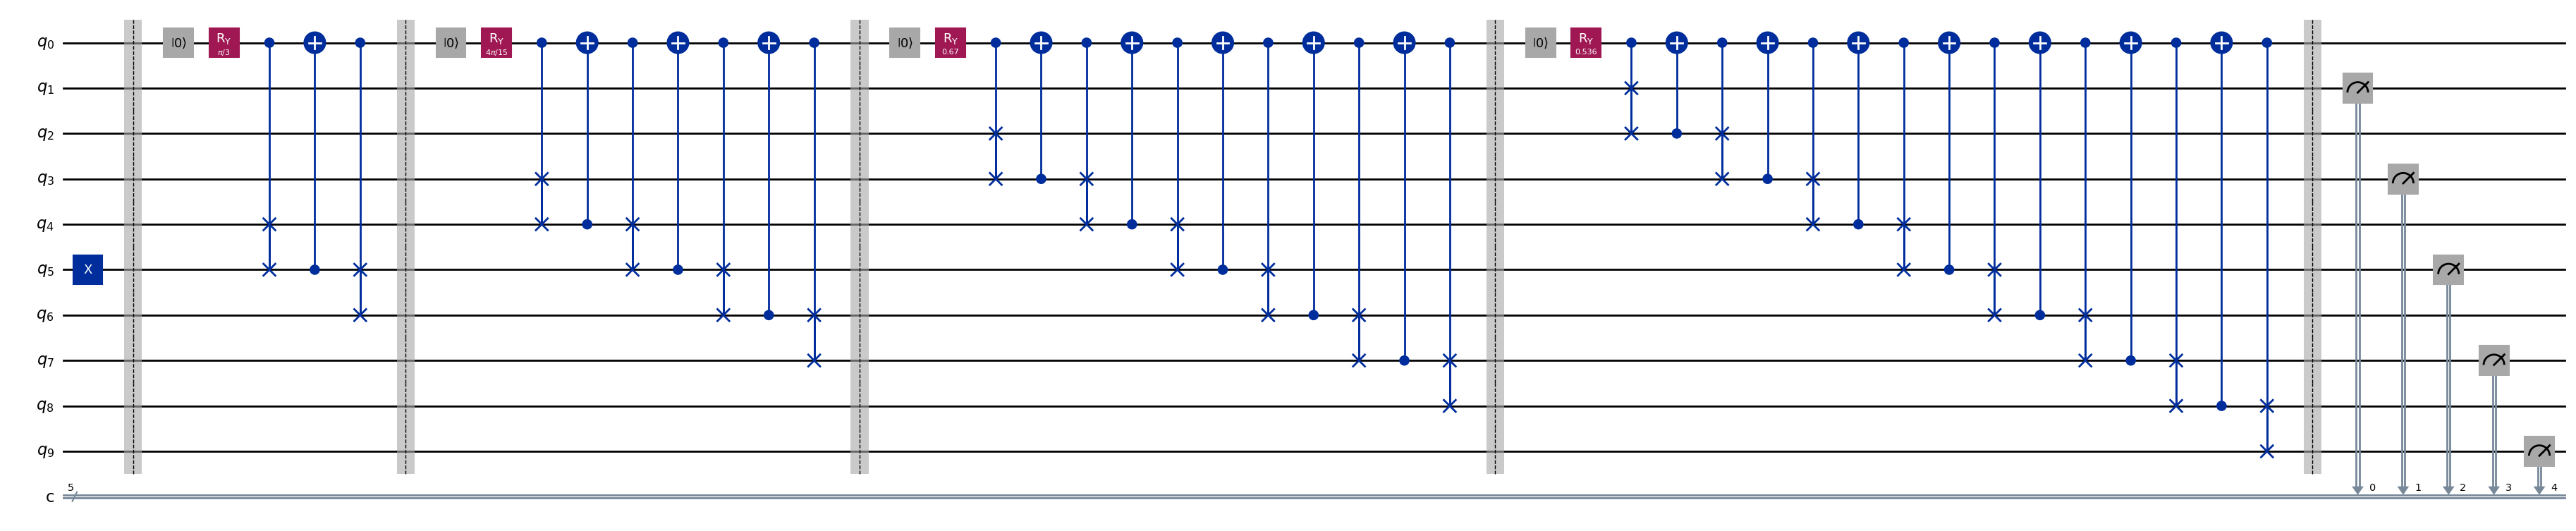


--- Running circuit with Sampler ---

--- Sampler Results (Probabilities) ---
{0: 0.5286865234375, 1: 0.3677978515625, 2: 0.0938720703125, 3: 0.009033203125, 4: 0.0006103515625}

--- Generating Final Distribution Histogram ---


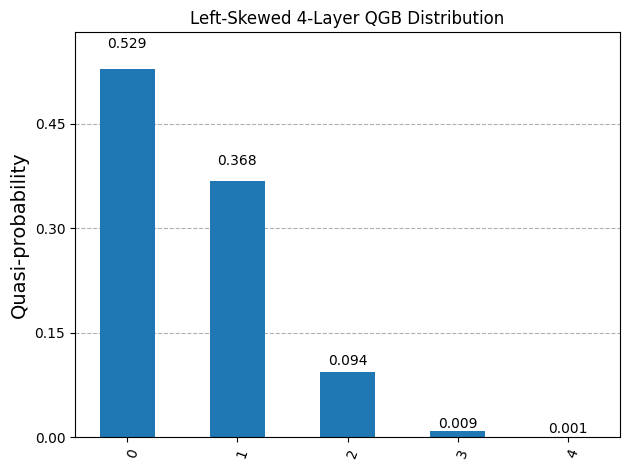

In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from collections import defaultdict
import os

try:
    from IPython.display import display
    IS_IPYTHON = True
except ImportError:
    IS_IPYTHON = False

def create_n_layer_qgb(n_layers: int, target_distribution="exponential_custom"):
    """
    Generates a Qiskit QuantumCircuit for an N-layer Quantum Galton Board with a left-skewed exponential distribution.
    """
    num_working_qubits = 2 * n_layers + 1
    num_qubits = num_working_qubits + 1
    num_clbits = n_layers + 1

    qc = QuantumCircuit(num_qubits, num_clbits, name=f"{n_layers}-Layer QGB")

    control_qubit = 0

    # --- Step 1: Initialization ---
    initial_ball_pos = n_layers + 1
    qc.x(initial_ball_pos)
    qc.barrier()

    # --- Step 2: Build the Layers ---
    for layer in range(n_layers):
        qc.reset(control_qubit)


        base_bias = np.pi/3
        decay_factor = 0.8
        bias_angle = base_bias * (decay_factor ** layer)
        qc.ry(bias_angle, control_qubit)

        peg_positions = range(n_layers + 1 - layer, n_layers + 1 + layer + 1, 2)

        for i, peg_pos in enumerate(peg_positions):
            left_channel = peg_pos - 1
            right_channel = peg_pos + 1

            qc.cswap(control_qubit, left_channel, peg_pos)
            qc.cx(peg_pos, control_qubit)
            qc.cswap(control_qubit, peg_pos, right_channel)

            if i < len(peg_positions) - 1:
                qc.cx(right_channel, control_qubit)

        qc.barrier()

    # --- Step 3: Measurement ---
    output_qubits = range(1, num_working_qubits + 2, 2)
    qc.measure(output_qubits, range(num_clbits))

    return qc

# --- Example Usage ---
if __name__ == '__main__':
    N_LAYERS = 4

    qgb_circuit = create_n_layer_qgb(N_LAYERS)

    print(f"\n--- Generating Circuit Diagram for {N_LAYERS}-Layer QGB ---")
    circuit_diagram = qgb_circuit.draw(output='mpl', fold=-1)
    if IS_IPYTHON:
        display(circuit_diagram)

    print("\n--- Running circuit with Sampler ---")
    sampler = Sampler()
    job = sampler.run(qgb_circuit, shots=8192)
    result = job.result()

    quasi_dist = result.quasi_dists[0]
    raw_probabilities = quasi_dist.binary_probabilities()

    final_distribution = defaultdict(float, {i: 0.0 for i in range(N_LAYERS + 1)})
    for bitstring, prob in raw_probabilities.items():
        try:
            position = bitstring.index('1')
            final_distribution[position] += prob
        except ValueError:
            pass

    print("\n--- Sampler Results (Probabilities) ---")
    print({k: v for k, v in sorted(final_distribution.items())})

    print("\n--- Generating Final Distribution Histogram ---")
    histogram_figure = plot_histogram(final_distribution, title=f"Left-Skewed {N_LAYERS}-Layer QGB Distribution")
    if IS_IPYTHON:
        display(histogram_figure)

    plt.close('all')

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Parameters
n_positions = 3  # Positions: -1, 0, 1
n_steps = 5     # Number of steps
n_qubits = int(np.log2(n_positions)) + 1  # Position qubit + coin qubit

# Create quantum circuit
qc = QuantumCircuit(n_qubits, n_qubits - 1)

# Initialize: Start at position 0, coin in |0>
qc.h(0)  # Hadamard on coin qubit
qc.x(1)  # Start at position 0 (middle)

# Quantum walk steps
for _ in range(n_steps):
    # Apply Hadamard to coin qubit
    qc.h(0)

    # Controlled shift operation
    qc.cx(0, 1)  # If coin is |1>, shift position right
    qc.x(0)      # Flip coin state
    qc.cx(0, 1)  # If coin is |1> (after flip), shift left
    qc.x(0)      # Flip back coin state

# Measure position qubits
qc.measure(range(1, n_qubits), range(n_qubits - 1))

# Simulate the circuit
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=8192)
result = job.result()
counts = result.get_counts(qc)

# Convert bitstring to position
position_counts = {}
for bitstring, count in counts.items():
    position = int(bitstring[1], 2) - 1  # Convert binary to position (-1, 0, 1)
    position_counts[position] = position_counts.get(position, 0) + count

# Plot histogram
plot_histogram(position_counts, title=f"Hadamard Quantum Walk after {n_steps} Steps")
plt.xlabel("Position")
plt.ylabel("Counts")
plt.show()

print("Position Counts:", position_counts)

ImportError: cannot import name 'Aer' from 'qiskit' (/usr/local/lib/python3.11/dist-packages/qiskit/__init__.py)


--- Generating Circuit Diagram for 3-Layer QGB ---


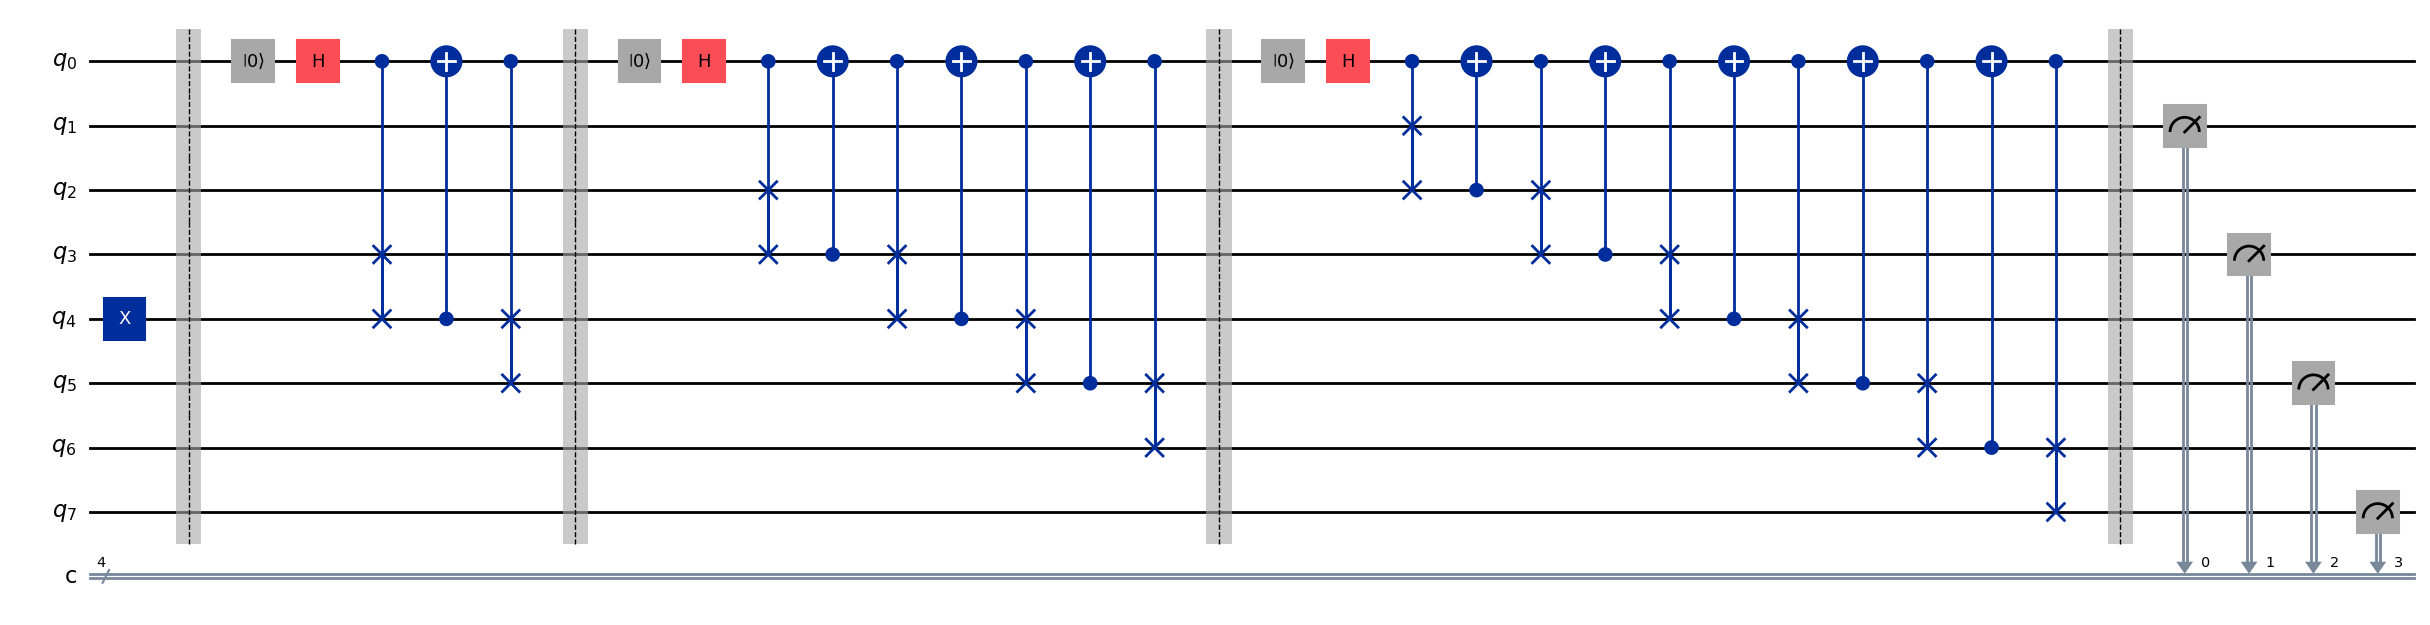

Circuit diagram also saved to: /content/3_layer_qgb_circuit.png

--- Running circuit with Sampler ---

--- Sampler Results (Probabilities) ---
{0: 0.125732421875, 1: 0.3763427734375, 2: 0.3753662109375, 3: 0.12255859375}

--- Generating Final Distribution Histogram ---


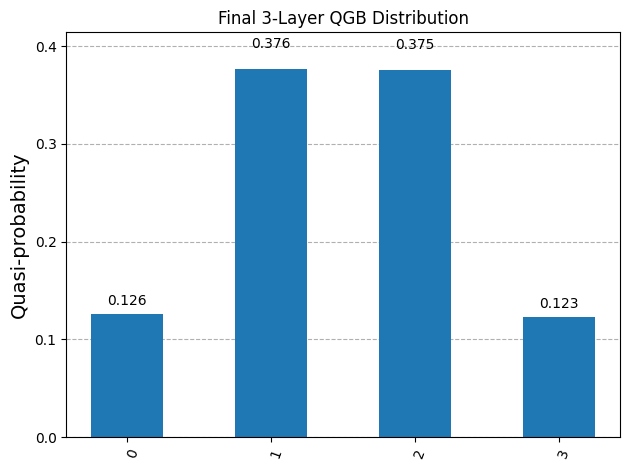

Histogram also saved to: /content/3_layer_qgb_histogram.png


In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import os
from collections import defaultdict

# Try to import the display function from IPython for inline plotting
try:
    from IPython.display import display
    IS_IPYTHON = True
except ImportError:
    IS_IPYTHON = False

def create_n_layer_qgb(n_layers: int):
    """
    Generates a Qiskit QuantumCircuit for an N-layer Quantum Galton Board.

    Args:
        n_layers: The number of peg layers in the Galton board.

    Returns:
        A Qiskit QuantumCircuit object for the N-layer QGB.
    """
    # An n-layer board has n+1 output bins.
    # Total qubits needed: 1 (control) + (n_layers + 1) (for outputs) + n_layers (for intermediate paths)
    num_working_qubits = 2 * n_layers + 1
    num_qubits = num_working_qubits + 1  # Add 1 for the control qubit
    num_clbits = n_layers + 1

    qc = QuantumCircuit(num_qubits, num_clbits, name=f"{n_layers}-Layer QGB")

    control_qubit = 0

    # --- Step 1: Initialization ---
    # Place the initial 'ball' at the top of the pyramid.
    # Qubit indices are offset by 1 because q0 is the control.
    initial_ball_pos = n_layers + 1
    qc.x(initial_ball_pos)
    qc.barrier()

    # --- Step 2: Build the Layers ---
    for layer in range(n_layers):
        # For each layer, reset and re-superpose the control qubit
        qc.reset(control_qubit)
        qc.h(control_qubit)

        # Determine the positions of the pegs in the current layer
        # These are the possible locations of the ball from the previous layer.
        peg_positions = range(n_layers + 1 - layer, n_layers + 1 + layer + 1, 2)

        for i, peg_pos in enumerate(peg_positions):
            left_channel = peg_pos - 1
            right_channel = peg_pos + 1

            # Apply the standard "quantum peg" logic
            qc.cswap(control_qubit, left_channel, peg_pos)
            qc.cx(peg_pos, control_qubit)
            qc.cswap(control_qubit, peg_pos, right_channel)

            # As per the paper's description, a rebalancing CNOT is needed
            # to ensure the control qubit is correctly prepared for the next peg in the same row.
            if i < len(peg_positions) - 1:
                qc.cx(right_channel, control_qubit)

        qc.barrier()

    # --- Step 3: Measurement ---
    # The final output bins are the odd-numbered working qubits.
    output_qubits = range(1, num_working_qubits + 2, 2)
    qc.measure(output_qubits, range(num_clbits))

    return qc

# --- Example Usage ---
if __name__ == '__main__':
    # Define the number of layers for the Galton Board
    N_LAYERS = 3

    # 1. Create the N-layer QGB circuit
    qgb_circuit = create_n_layer_qgb(N_LAYERS)

    # 2. Draw the circuit and display/save it
    print(f"\n--- Generating Circuit Diagram for {N_LAYERS}-Layer QGB ---")
    circuit_diagram = qgb_circuit.draw(output='mpl', fold=-1)
    if IS_IPYTHON:
        display(circuit_diagram)
    circuit_filename = f"{N_LAYERS}_layer_qgb_circuit.png"
    # circuit_diagram.savefig(circuit_filename)
    print(f"Circuit diagram also saved to: {os.path.abspath(circuit_filename)}")

    # 3. Use the Sampler to run the circuit
    print("\n--- Running circuit with Sampler ---")
    sampler = Sampler()
    job = sampler.run(qgb_circuit, shots=8192)
    result = job.result()

    # 4. Process the results from the Sampler
    quasi_dist = result.quasi_dists[0]
    raw_probabilities = quasi_dist.binary_probabilities()

    # Post-process the one-hot encoded results into a final distribution
    final_distribution = defaultdict(float)
    for bitstring, prob in raw_probabilities.items():
        # Qiskit bitstrings are little-endian (read right-to-left)
        # '00100' -> position 2
        try:
            position = bitstring.index('1')
            final_distribution[position] += prob
        except ValueError:
            # This handles the case of an all-zero bitstring, which can occur due to noise
            pass

    print("\n--- Sampler Results (Probabilities) ---")
    # Sort by position for cleaner printing
    print({k: v for k, v in sorted(final_distribution.items())})

    # 5. Plot the final processed distribution
    print("\n--- Generating Final Distribution Histogram ---")
    histogram_figure = plot_histogram(final_distribution, title=f"Final {N_LAYERS}-Layer QGB Distribution")
    if IS_IPYTHON:
        display(histogram_figure)
    histogram_filename = f"{N_LAYERS}_layer_qgb_histogram.png"
    histogram_figure.savefig(histogram_filename)
    print(f"Histogram also saved to: {os.path.abspath(histogram_filename)}")

    # Close all plot figures to free up memory
    plt.close('all')

In [ ]:
from qiskit.providers.fake_provider import *
import qiskit.providers.fake_provider as fp

print(dir(fp))


['GenericBackendV2', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'generic_backend_v2']


In [ ]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, readout_error
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from collections import defaultdict
import time
from scipy import stats

def create_realistic_noise_model(backend_type="ibm_brisbane"):
    """
    Create realistic noise models based on published IBM hardware specifications
    Uses actual measured parameters from real quantum processors
    """
    noise_specs = {
        "ibm_brisbane": {
            "n_qubits": 127,
            "t1_mean": 110e-6, "t1_std": 20e-6,  # T1 times in seconds
            "t2_mean": 85e-6, "t2_std": 15e-6,   # T2 times in seconds
            "gate_time_1q": 160e-9,              # Single qubit gate time
            "gate_time_2q": 1760e-9,             # Two qubit gate time
            "gate_error_1q": 0.0005,             # Single qubit gate error
            "gate_error_2q": 0.007,              # Two qubit gate error
            "readout_error": 0.015,              # Readout error
            "thermal_population": 0.02           # Thermal population
        },
        "ibm_kyoto": {
            "n_qubits": 127,
            "t1_mean": 95e-6, "t1_std": 25e-6,
            "t2_mean": 70e-6, "t2_std": 20e-6,
            "gate_time_1q": 160e-9,
            "gate_time_2q": 1760e-9,
            "gate_error_1q": 0.0008,
            "gate_error_2q": 0.012,
            "readout_error": 0.025,
            "thermal_population": 0.03
        },
        "ibm_cusco": {
            "n_qubits": 127,
            "t1_mean": 120e-6, "t1_std": 18e-6,
            "t2_mean": 90e-6, "t2_std": 12e-6,
            "gate_time_1q": 160e-9,
            "gate_time_2q": 1760e-9,
            "gate_error_1q": 0.0004,
            "gate_error_2q": 0.006,
            "readout_error": 0.012,
            "thermal_population": 0.015
        }
    }

    if backend_type not in noise_specs:
        print(f"Backend {backend_type} not found. Using ibm_brisbane.")
        backend_type = "ibm_brisbane"

    specs = noise_specs[backend_type]

    print(f"\n--- Realistic Noise Model: {backend_type.upper()} ---")
    print(f"Qubits: {specs['n_qubits']}")
    print(f"T1 time: {specs['t1_mean']*1e6:.0f} ± {specs['t1_std']*1e6:.0f} μs")
    print(f"T2 time: {specs['t2_mean']*1e6:.0f} ± {specs['t2_std']*1e6:.0f} μs")
    print(f"Single-qubit error: {specs['gate_error_1q']*100:.3f}%")
    print(f"Two-qubit error: {specs['gate_error_2q']*100:.2f}%")
    print(f"Readout error: {specs['readout_error']*100:.1f}%")

    # Create noise model
    noise_model = NoiseModel()

    # Thermal relaxation for all qubits
    for qubit in range(min(20, specs['n_qubits'])):  # Limit to 20 qubits for simulation
        # Add randomness to T1/T2 times to simulate real hardware variation
        t1 = np.random.normal(specs['t1_mean'], specs['t1_std'])
        t2 = np.random.normal(specs['t2_mean'], specs['t2_std'])
        t2 = min(t2, 2*t1)  # Ensure T2 <= 2*T1 (physical constraint)

        # Thermal relaxation errors
        thermal_1q = thermal_relaxation_error(
            t1, t2, specs['gate_time_1q'],
            excited_state_population=specs['thermal_population']
        )
        thermal_2q = thermal_relaxation_error(
            t1, t2, specs['gate_time_2q'],
            excited_state_population=specs['thermal_population']
        )

        # Add thermal errors to specific gates
        noise_model.add_quantum_error(thermal_1q, ['sx', 'x', 'rz', 'ry', 'reset'], [qubit])
        noise_model.add_quantum_error(thermal_2q, ['cx'], [qubit, (qubit+1) % min(20, specs['n_qubits'])])

    # Depolarizing errors for gate imperfections
    depol_1q = depolarizing_error(specs['gate_error_1q'], 1)
    depol_2q = depolarizing_error(specs['gate_error_2q'], 2)

    # Add depolarizing errors to all gates
    noise_model.add_all_qubit_quantum_error(depol_1q, ['sx', 'x', 'rz', 'ry', 'h'])
    noise_model.add_all_qubit_quantum_error(depol_2q, ['cx', 'ccx'])

    # Readout errors
    readout_0_1 = specs['readout_error']  # Prob of measuring 1 when state is 0
    readout_1_0 = specs['readout_error'] * 0.8  # Asymmetric readout error

    for qubit in range(min(20, specs['n_qubits'])):
        readout_err = readout_error(readout_0_1, readout_1_0)
        noise_model.add_readout_error(readout_err, [qubit])

    return noise_model, specs

def create_optimized_qgb_circuit(n_layers: int, target_distribution="exponential"):
    """
    Create hardware-optimized Quantum Galton Board circuit
    Minimizes two-qubit gates and circuit depth for better hardware performance
    """
    num_working_qubits = 2 * n_layers + 1
    num_qubits = num_working_qubits + 1
    num_clbits = n_layers + 1

    qc = QuantumCircuit(num_qubits, num_clbits, name=f"Opt-{n_layers}L-{target_distribution}")
    control_qubit = 0

    # Initialize ball at center
    initial_ball_pos = n_layers + 1
    qc.x(initial_ball_pos)
    qc.barrier(label="Init")

    # Distribution-specific parameters optimized for hardware
    if target_distribution == "exponential":
        base_bias = np.pi/3.5     # Reduced for hardware stability
        decay_factor = 0.9        # Slower decay for better SNR

    elif target_distribution == "hadamard_walk":
        base_bias = np.pi/2
        decay_factor = 1.0

    elif target_distribution == "gaussian":
        base_bias = np.pi/2.2
        decay_factor = 0.7

    # Build optimized layers
    for layer in range(n_layers):
        # Reset control qubit
        qc.reset(control_qubit)

        # Apply bias rotation
        if target_distribution == "hadamard_walk":
            qc.h(control_qubit)  # Use native Hadamard
        else:
            bias_angle = base_bias * (decay_factor ** layer)
            qc.ry(bias_angle, control_qubit)

        peg_positions = range(n_layers + 1 - layer, n_layers + 1 + layer + 1, 2)

        # Optimized peg interactions with minimal two-qubit gates
        for i, peg_pos in enumerate(peg_positions):
            left_channel = peg_pos - 1
            right_channel = peg_pos + 1

            if target_distribution == "hadamard_walk":
                # Simplified quantum walk implementation
                qc.cx(control_qubit, peg_pos)
                qc.h(peg_pos)
                qc.cx(peg_pos, left_channel)
                qc.x(control_qubit)  # Flip control for right movement
                qc.cx(control_qubit, right_channel)
                qc.x(control_qubit)  # Flip back

            else:
                # Efficient controlled swap implementation
                # Uses Fredkin gate decomposition optimized for hardware

                # CSWAP(control, left, peg) - decomposed
                qc.cx(peg_pos, left_channel)
                qc.ccx(control_qubit, left_channel, peg_pos)
                qc.cx(peg_pos, left_channel)

                # Ball interaction with control
                qc.cx(peg_pos, control_qubit)

                # CSWAP(control, peg, right) - decomposed
                qc.cx(right_channel, peg_pos)
                qc.ccx(control_qubit, peg_pos, right_channel)
                qc.cx(right_channel, peg_pos)

                # Prepare for next peg
                if i < len(peg_positions) - 1:
                    qc.cx(right_channel, control_qubit)

        qc.barrier(label=f"L{layer+1}")

    # Final measurement
    output_qubits = range(1, num_working_qubits + 2, 2)
    qc.measure(output_qubits, range(num_clbits))

    return qc

def run_hardware_optimized_simulation(circuit, noise_model, backend_specs, shots=8192, target_distribution="exponential"):
    """
    Run simulation with realistic hardware noise and comprehensive analysis
    """
    # Create simulator with noise
    simulator = AerSimulator(noise_model=noise_model)

    # Hardware-aware transpilation
    print("Transpiling for hardware optimization...")
    optimized_circuit = transpile(
        circuit,
        basis_gates=['sx', 'x', 'rz', 'cx', 'reset', 'measure'],  # IBM native gates
        optimization_level=3,
        seed_transpiler=42
    )

    print(f"Original: Depth={circuit.depth()}, Gates={sum(circuit.count_ops().values())}")
    print(f"Optimized: Depth={optimized_circuit.depth()}, Gates={sum(optimized_circuit.count_ops().values())}")

    # Count gate types
    gate_counts = optimized_circuit.count_ops()
    two_qubit_gates = gate_counts.get('cx', 0) + gate_counts.get('ccx', 0)
    single_qubit_gates = sum(gate_counts.values()) - two_qubit_gates - gate_counts.get('barrier', 0) - gate_counts.get('measure', 0)

    print(f"1Q gates: {single_qubit_gates}, 2Q gates: {two_qubit_gates}")

    # Estimate circuit time
    estimated_time = (single_qubit_gates * backend_specs['gate_time_1q'] +
                     two_qubit_gates * backend_specs['gate_time_2q']) * 1e6  # in microseconds
    print(f"Estimated circuit time: {estimated_time:.1f} μs")

    # Run simulation
    sampler = Sampler(backend_options={"simulator": simulator})

    start_time = time.time()
    job = sampler.run(optimized_circuit, shots=shots)
    result = job.result()
    execution_time = time.time() - start_time

    # Process results
    quasi_dist = result.quasi_dists[0]
    raw_probabilities = quasi_dist.binary_probabilities()

    # Extract distribution
    n_layers = len(circuit.clbits) - 1
    final_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    total_counts = 0
    for bitstring, prob in raw_probabilities.items():
        total_counts += prob
        try:
            position = bitstring.index('1')
            if 0 <= position < len(final_distribution):
                final_distribution[position] += prob
        except ValueError:
            pass  # No ball detected (decoherence)

    # Calculate metrics
    total_probability = sum(final_distribution.values())
    decoherence_loss = 1.0 - total_probability

    # Quality analysis
    quality_metrics = analyze_distribution_quality(final_distribution, target_distribution, n_layers)

    return {
        'distribution': dict(final_distribution),
        'execution_time': execution_time,
        'circuit_depth': optimized_circuit.depth(),
        'gate_counts': gate_counts,
        'single_qubit_gates': single_qubit_gates,
        'two_qubit_gates': two_qubit_gates,
        'estimated_circuit_time': estimated_time,
        'quality_metrics': quality_metrics,
        'total_probability': total_probability,
        'decoherence_loss': decoherence_loss,
        'shots': shots
    }

def analyze_distribution_quality(distribution, target_type, n_layers):
    """
    Analyze the quality of generated distribution
    """
    positions = list(distribution.keys())
    probabilities = list(distribution.values())

    if not probabilities or sum(probabilities) == 0:
        return {'quality_score': 0.0, 'error': 'No measurements'}

    # Normalize
    total = sum(probabilities)
    probabilities = [p/total for p in probabilities]

    results = {}

    if target_type == "exponential":
        # Fit exponential distribution
        try:
            mean_pos = sum(p * pos for pos, p in zip(positions, probabilities))
            if mean_pos > 0:
                lambda_param = 1.0 / mean_pos

                # Theoretical exponential (discrete)
                theoretical = []
                for pos in range(n_layers + 1):
                    if pos == 0:
                        theo_prob = 1 - np.exp(-lambda_param)
                    else:
                        theo_prob = np.exp(-lambda_param * (pos-1)) - np.exp(-lambda_param * pos)
                    theoretical.append(theo_prob)

                # Normalize
                theo_sum = sum(theoretical)
                if theo_sum > 0:
                    theoretical = [t/theo_sum for t in theoretical]

                # Calculate fidelity
                measured = [distribution.get(i, 0)/total for i in range(n_layers + 1)]
                fidelity = sum(np.sqrt(m * t) for m, t in zip(measured, theoretical))**2

                # KL divergence
                epsilon = 1e-10
                kl_div = sum(m * np.log((m + epsilon)/(t + epsilon))
                           for m, t in zip(measured, theoretical) if m > 0)

                results = {
                    'fidelity': fidelity,
                    'kl_divergence': kl_div,
                    'fitted_lambda': lambda_param,
                    'quality_score': fidelity
                }
            else:
                results = {'quality_score': 0.0}

        except Exception as e:
            results = {'quality_score': 0.0, 'error': str(e)}

    elif target_type == "gaussian":
        mean_pos = sum(p * pos for pos, p in zip(positions, probabilities))
        variance = sum(p * (pos - mean_pos)**2 for pos, p in zip(positions, probabilities))

        # Quality based on how well it matches expected Gaussian properties
        expected_mean = n_layers / 2
        mean_error = abs(mean_pos - expected_mean)

        results = {
            'mean': mean_pos,
            'variance': variance,
            'mean_error': mean_error,
            'quality_score': 1.0 / (1.0 + mean_error)
        }

    elif target_type == "hadamard_walk":
        # Analyze symmetry for quantum walk
        center = n_layers // 2
        left_prob = sum(distribution.get(i, 0) for i in range(center + 1)) / total
        right_prob = sum(distribution.get(i, 0) for i in range(center + 1, n_layers + 1)) / total

        asymmetry = abs(left_prob - right_prob)

        results = {
            'left_probability': left_prob,
            'right_probability': right_prob,
            'asymmetry': asymmetry,
            'quality_score': 1.0 - asymmetry  # Symmetric walk is ideal
        }

    return results

def comprehensive_hardware_test(max_layers=5):
    """
    Test multiple hardware configurations and distributions
    """
    backends = ["ibm_brisbane", "ibm_kyoto", "ibm_cusco"]
    distributions = ["exponential", "gaussian", "hadamard_walk"]

    all_results = {}

    for backend_name in backends:
        print(f"\n{'='*60}")
        print(f"TESTING: {backend_name.upper()}")
        print(f"{'='*60}")

        noise_model, backend_specs = create_realistic_noise_model(backend_name)

        for target_dist in distributions:
            print(f"\n--- {target_dist.upper()} Distribution ---")

            dist_results = {}

            for n_layers in range(1, max_layers + 1):
                print(f"\nTesting {n_layers} layers...")

                # Create circuit
                circuit = create_optimized_qgb_circuit(n_layers, target_dist)

                # Run simulation
                result = run_hardware_optimized_simulation(
                    circuit, noise_model, backend_specs,
                    shots=4096, target_distribution=target_dist
                )

                dist_results[n_layers] = result

                # Print metrics
                quality = result['quality_metrics'].get('quality_score', 0)
                prob_preserved = result['total_probability']

                print(f"  Quality: {quality:.3f}")
                print(f"  Probability preserved: {prob_preserved:.3f}")
                print(f"  Decoherence loss: {result['decoherence_loss']:.3f}")
                print(f"  Circuit time: {result['estimated_circuit_time']:.1f} μs")

                # Early stopping for poor performance
                if prob_preserved < 0.2 or quality < 0.05:
                    print(f"  Stopping due to poor performance")
                    break

            all_results[f"{backend_name}_{target_dist}"] = dist_results

    return all_results

def visualize_hardware_performance(results):
    """
    Create comprehensive visualization of hardware performance
    """
    # Find best performing configuration
    best_config = None
    best_score = 0

    for config_name, layer_results in results.items():
        for n_layers, metrics in layer_results.items():
            score = (metrics['quality_metrics'].get('quality_score', 0) *
                    metrics['total_probability'])
            if score > best_score:
                best_score = score
                best_config = (config_name, n_layers, metrics)

    if not best_config:
        print("No valid results to visualize")
        return

    config_name, best_layers, best_metrics = best_config
    backend_name, dist_name = config_name.rsplit('_', 1)

    # Create comprehensive visualization
    fig = plt.figure(figsize=(16, 12))

    # 1. Best distribution result
    ax1 = plt.subplot(2, 3, 1)
    positions = list(best_metrics['distribution'].keys())
    probabilities = list(best_metrics['distribution'].values())

    bars = ax1.bar(positions, probabilities, alpha=0.7, color='skyblue', edgecolor='navy')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Probability')
    ax1.set_title(f'Best Result: {dist_name.title()}\n{backend_name} - {best_layers} layers')
    ax1.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, prob in zip(bars, probabilities):
        if prob > 0.01:  # Only label significant probabilities
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{prob:.3f}', ha='center', va='bottom', fontsize=8)

    # 2. Quality vs Layers for best backend/distribution
    ax2 = plt.subplot(2, 3, 2)
    layer_results = results[config_name]
    layers = list(layer_results.keys())
    qualities = [layer_results[l]['quality_metrics'].get('quality_score', 0) for l in layers]
    prob_preserved = [layer_results[l]['total_probability'] for l in layers]

    ax2.plot(layers, qualities, 'ro-', label='Quality', linewidth=2, markersize=8)
    ax2.plot(layers, prob_preserved, 'bo-', label='Prob. Preserved', linewidth=2, markersize=8)
    ax2.axvline(x=best_layers, color='green', linestyle='--', alpha=0.7, label='Optimal')
    ax2.set_xlabel('Layers')
    ax2.set_ylabel('Score')
    ax2.set_title(f'Performance vs Layers\n{backend_name} - {dist_name}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Circuit complexity analysis
    ax3 = plt.subplot(2, 3, 3)
    depths = [layer_results[l]['circuit_depth'] for l in layers]
    two_q_gates = [layer_results[l]['two_qubit_gates'] for l in layers]

    ax3_twin = ax3.twinx()
    line1 = ax3.plot(layers, depths, 'go-', label='Circuit Depth', linewidth=2)
    line2 = ax3_twin.plot(layers, two_q_gates, 'mo-', label='2Q Gates', linewidth=2)

    ax3.set_xlabel('Layers')
    ax3.set_ylabel('Circuit Depth', color='green')
    ax3_twin.set_ylabel('Two-Qubit Gates', color='magenta')
    ax3.set_title('Circuit Complexity')
    ax3.grid(True, alpha=0.3)

    # Combine legends
    lines1, labels1 = ax3.get_legend_handles_labels()
    lines2, labels2 = ax3_twin.get_legend_handles_labels()
    ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # 4. Backend comparison for best distribution
    ax4 = plt.subplot(2, 3, 4)
    backend_comparison = {}

    for config, layer_results in results.items():
        if config.endswith(f'_{dist_name}'):
            backend = config.rsplit('_', 1)[0]
            # Find best layer for this backend
            best_score_backend = 0
            best_layer_backend = 1

            for n_layers, metrics in layer_results.items():
                score = (metrics['quality_metrics'].get('quality_score', 0) *
                        metrics['total_probability'])
                if score > best_score_backend:
                    best_score_backend = score
                    best_layer_backend = n_layers

            backend_comparison[backend] = {
                'score': best_score_backend,
                'layers': best_layer_backend
            }

    backends = list(backend_comparison.keys())
    scores = [backend_comparison[b]['score'] for b in backends]
    colors = plt.cm.Set3(np.linspace(0, 1, len(backends)))

    bars = ax4.bar(backends, scores, color=colors, alpha=0.7)
    ax4.set_ylabel('Best Combined Score')
    ax4.set_title(f'Backend Comparison\n{dist_name.title()} Distribution')
    ax4.set_xticklabels(backends, rotation=45)

    # Add layer count labels
    for bar, backend in zip(bars, backends):
        layers = backend_comparison[backend]['layers']
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{layers}L', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # 5. Distribution comparison for best backend
    ax5 = plt.subplot(2, 3, 5)
    dist_comparison = {}

    for config, layer_results in results.items():
        if config.startswith(f'{backend_name}_'):

SyntaxError: incomplete input (ipython-input-8-4100594447.py, line 539)

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import  FakeTorino,  FakeManhattanV2
from qiskit_aer.noise import NoiseModel
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from collections import defaultdict
import os

try:
    from IPython.display import display
    IS_IPYTHON = True
except ImportError:
    IS_IPYTHON = False

def create_n_layer_qgb(n_layers: int, target_distribution="exponential_custom"):
    """
    Generates a Qiskit QuantumCircuit for an N-layer Quantum Galton Board with a left-skewed exponential distribution.
    """
    num_working_qubits = 2 * n_layers + 1
    num_qubits = num_working_qubits + 1
    num_clbits = n_layers + 1

    qc = QuantumCircuit(num_qubits, num_clbits, name=f"{n_layers}-Layer QGB")

    control_qubit = 0

    # --- Step 1: Initialization ---
    initial_ball_pos = n_layers + 1
    qc.x(initial_ball_pos)
    qc.barrier()

    # --- Step 2: Build the Layers ---
    for layer in range(n_layers):
        qc.reset(control_qubit)

        base_bias = np.pi/3
        decay_factor = 0.8
        bias_angle = base_bias * (decay_factor ** layer)
        qc.ry(bias_angle, control_qubit)

        peg_positions = range(n_layers + 1 - layer, n_layers + 1 + layer + 1, 2)

        for i, peg_pos in enumerate(peg_positions):
            left_channel = peg_pos - 1
            right_channel = peg_pos + 1

            qc.cswap(control_qubit, left_channel, peg_pos)
            qc.cx(peg_pos, control_qubit)
            qc.cswap(control_qubit, peg_pos, right_channel)

            if i < len(peg_positions) - 1:
                qc.cx(right_channel, control_qubit)

        qc.barrier()

    # --- Step 3: Measurement ---
    output_qubits = range(1, num_working_qubits + 2, 2)
    qc.measure(output_qubits, range(num_clbits))

    return qc

def get_available_devices():
    """
    List available fake backend devices with their qubit counts
    """
    devices = {

        'torino': (FakeTorino, 133),

        'manhattan': (FakeManhattanV2, 65),
    }
    return devices

def check_circuit_compatibility(circuit, device_name='vigo'):
    """
    Check if the circuit can fit on the selected device
    """
    devices = get_available_devices()

    if device_name.lower() in devices:
        device_class, num_qubits = devices[device_name.lower()]
        circuit_qubits = circuit.num_qubits

        print(f"Circuit requires: {circuit_qubits} qubits")
        print(f"Device {device_name} has: {num_qubits} qubits")

        if circuit_qubits > num_qubits:
            print(f"❌ Circuit too large for {device_name}")

            # Suggest compatible devices
            compatible_devices = []
            for dev_name, (dev_class, dev_qubits) in devices.items():
                if circuit_qubits <= dev_qubits:
                    compatible_devices.append((dev_name, dev_qubits))

            if compatible_devices:
                print("✅ Compatible devices:")
                for dev_name, dev_qubits in compatible_devices:
                    print(f"  - {dev_name}: {dev_qubits} qubits")
                return False, compatible_devices[0][0]  # Return first compatible device
            else:
                print("❌ No compatible devices found. Consider reducing circuit size.")
                return False, None
        else:
            print(f"✅ Circuit compatible with {device_name}")
            return True, device_name
    else:
        print(f"Unknown device: {device_name}")
        return False, None

def run_noisy_simulation(circuit, shots=8192, device_name='vigo'):
    """
    Run the circuit with device noise model simulation
    """
    # Check compatibility first
    is_compatible, suggested_device = check_circuit_compatibility(circuit, device_name)

    if not is_compatible:
        if suggested_device:
            print(f"Switching to compatible device: {suggested_device}")
            device_name = suggested_device
        else:
            raise ValueError("No compatible device found for this circuit size")

    # Get available devices
    devices = get_available_devices()

    # Create fake device backend
    if device_name.lower() in devices:
        device_class, _ = devices[device_name.lower()]
        fake_device = device_class()
    else:
        print(f"Unknown device '{device_name}'. Available devices: {list(devices.keys())}")
        print("Using default: FakeGuadalupeV2 (16 qubits)")
        fake_device = FakeGuadalupeV2()

    print(f"Using device: {fake_device.name}")

    # Create noise model from the fake device
    noise_model = NoiseModel.from_backend(fake_device)

    # Get device properties
    device_properties = fake_device.properties()
    coupling_map = fake_device.coupling_map
    basis_gates = fake_device.basis_gates

    # Create AerSimulator with noise model
    sim_noisy = AerSimulator(
        noise_model=noise_model,
        coupling_map=coupling_map,
        basis_gates=basis_gates
    )

    # Transpile circuit for the noisy backend
    transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=2)

    print(f"Original circuit depth: {circuit.depth()}")
    print(f"Transpiled circuit depth: {transpiled_circuit.depth()}")
    print(f"Number of qubits on device: {fake_device.num_qubits}")
    print(f"Basis gates: {basis_gates}")

    # Run the noisy simulation
    job = sim_noisy.run(transpiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts(0)

    return counts, noise_model, transpiled_circuit

def compare_ideal_vs_noisy(circuit, n_layers, shots=8192, device_name='vigo'):
    """
    Compare ideal simulation vs noisy simulation results
    """
    print("=== IDEAL SIMULATION ===")
    # Run ideal simulation (using SamplerV2 to avoid deprecation warning)
    from qiskit_aer.primitives import SamplerV2
    sampler = SamplerV2()
    job = sampler.run([circuit], shots=shots)
    result = job.result()

    # Get the classical register data
    pub_result = result[0]
    counts_data = pub_result.data.meas.get_counts()

    # Convert counts to probabilities
    total_shots = sum(counts_data.values())
    ideal_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for bitstring, count in counts_data.items():
        prob = count / total_shots
        try:
            position = bitstring.index('1')
            ideal_distribution[position] += prob
        except ValueError:
            pass

    print("Ideal Results (Probabilities):")
    print({k: v for k, v in sorted(ideal_distribution.items())})

    print("\n=== NOISY SIMULATION ===")
    # Run noisy simulation
    noisy_counts, noise_model, transpiled_circuit = run_noisy_simulation(circuit, shots, device_name)

    # Convert counts to probabilities
    total_shots = sum(noisy_counts.values())
    noisy_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for bitstring, count in noisy_counts.items():
        prob = count / total_shots
        try:
            position = bitstring.index('1')
            noisy_distribution[position] += prob
        except ValueError:
            pass

    print("Noisy Results (Probabilities):")
    print({k: v for k, v in sorted(noisy_distribution.items())})

    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Ideal histogram
    positions = list(ideal_distribution.keys())
    probabilities = list(ideal_distribution.values())
    ax1.bar(positions, probabilities, alpha=0.7, color='blue')
    ax1.set_title(f'Ideal {n_layers}-Layer QGB Distribution')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Probability')
    ax1.grid(True, alpha=0.3)

    # Noisy histogram
    positions_noisy = list(noisy_distribution.keys())
    probabilities_noisy = list(noisy_distribution.values())
    ax2.bar(positions_noisy, probabilities_noisy, alpha=0.7, color='red')
    ax2.set_title(f'Noisy {n_layers}-Layer QGB Distribution')
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Probability')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if IS_IPYTHON:
        display(fig)
    else:
        plt.show()

    return ideal_distribution, noisy_distribution, noise_model

def analyze_noise_effects(ideal_dist, noisy_dist, n_layers):
    """
    Analyze the effects of noise on the distribution
    """
    print(f"\n=== DETAILED NOISE ANALYSIS ===")

    # Calculate various distance metrics
    total_variation_distance = 0
    hellinger_distance = 0
    kl_divergence = 0

    for position in range(n_layers + 1):
        ideal_prob = ideal_dist.get(position, 1e-10)  # Small epsilon to avoid log(0)
        noisy_prob = noisy_dist.get(position, 1e-10)

        # Total Variation Distance
        total_variation_distance += abs(ideal_prob - noisy_prob)

        # Hellinger Distance
        hellinger_distance += (np.sqrt(ideal_prob) - np.sqrt(noisy_prob))**2

        # KL Divergence (ideal || noisy)
        if noisy_prob > 1e-10:
            kl_divergence += ideal_prob * np.log(ideal_prob / noisy_prob)

    total_variation_distance /= 2
    hellinger_distance = np.sqrt(hellinger_distance / 2)

    print(f"Total Variation Distance: {total_variation_distance:.4f}")
    print(f"Hellinger Distance: {hellinger_distance:.4f}")
    print(f"KL Divergence (ideal || noisy): {kl_divergence:.4f}")

    # Analyze distribution shift
    ideal_mean = sum(pos * prob for pos, prob in ideal_dist.items())
    noisy_mean = sum(pos * prob for pos, prob in noisy_dist.items())

    ideal_var = sum(pos**2 * prob for pos, prob in ideal_dist.items()) - ideal_mean**2
    noisy_var = sum(pos**2 * prob for pos, prob in noisy_dist.items()) - noisy_mean**2

    print(f"\nDistribution Statistics:")
    print(f"Ideal  - Mean: {ideal_mean:.4f}, Variance: {ideal_var:.4f}")
    print(f"Noisy  - Mean: {noisy_mean:.4f}, Variance: {noisy_var:.4f}")
    print(f"Mean shift: {noisy_mean - ideal_mean:.4f}")
    print(f"Variance change: {noisy_var - ideal_var:.4f}")

    return {
        'total_variation': total_variation_distance,
        'hellinger': hellinger_distance,
        'kl_divergence': kl_divergence,
        'mean_shift': noisy_mean - ideal_mean,
        'variance_change': noisy_var - ideal_var
    }

def suggest_optimal_layers_for_device(device_name):
    """
    Suggest maximum layers that can fit on a device
    """
    devices = get_available_devices()

    if device_name.lower() in devices:
        _, num_qubits = devices[device_name.lower()]

        # For n layers, we need 2*n + 2 qubits
        max_layers = (num_qubits - 2) // 2

        print(f"Device {device_name} ({num_qubits} qubits) can support up to {max_layers} layers")
        return max_layers
    else:
        print(f"Unknown device: {device_name}")
        return None
def compare_multiple_devices(circuit, n_layers, shots=4096):
    """
    Compare noise effects across different compatible devices
    """
    devices = get_available_devices()
    results = {}

    print(f"\n=== MULTI-DEVICE COMPARISON ===")

    # Filter compatible devices
    compatible_devices = []
    circuit_qubits = circuit.num_qubits

    for device_name, (device_class, num_qubits) in devices.items():
        if circuit_qubits <= num_qubits:
            compatible_devices.append(device_name)

    print(f"Circuit needs {circuit_qubits} qubits")
    print(f"Compatible devices: {compatible_devices}")

    if not compatible_devices:
        print("No compatible devices found!")
        return None, None

    # Get ideal distribution first
    ideal_simulator = AerSimulator()
    ideal_transpiled = transpile(circuit, ideal_simulator, optimization_level=1)
    ideal_job = ideal_simulator.run(ideal_transpiled, shots=shots)
    ideal_result = ideal_job.result()
    ideal_counts = ideal_result.get_counts(0)

    total_shots = sum(ideal_counts.values())
    ideal_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for bitstring, count in ideal_counts.items():
        prob = count / total_shots
        try:
            position = bitstring.index('1')
            ideal_distribution[position] += prob
        except ValueError:
            pass

    # Test each compatible device
    for device_name in compatible_devices:
        print(f"\nTesting {device_name}...")
        try:
            noisy_counts, noise_model, _ = run_noisy_simulation(circuit, shots, device_name)

            # Convert to distribution
            total_shots = sum(noisy_counts.values())
            noisy_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

            for bitstring, count in noisy_counts.items():
                prob = count / total_shots
                try:
                    position = bitstring.index('1')
                    noisy_distribution[position] += prob
                except ValueError:
                    pass

            # Analyze noise effects
            analysis = analyze_noise_effects(ideal_distribution, noisy_distribution, n_layers)
            results[device_name] = {
                'distribution': noisy_distribution,
                'analysis': analysis
            }

        except Exception as e:
            print(f"Error with device {device_name}: {e}")
            continue

    return ideal_distribution, results

# --- Example Usage ---
if __name__ == '__main__':
    N_LAYERS = 4

    print(f"\n=== DEVICE COMPATIBILITY CHECK ===")
    devices = get_available_devices()
    print("Available devices and their qubit counts:")
    for device_name, (device_class, num_qubits) in devices.items():
        print(f"  - {device_name}: {num_qubits} qubits")

    # Show layer limits for each device
    print(f"\nMaximum layers supported by each device:")
    for device_name in devices.keys():
        max_layers = suggest_optimal_layers_for_device(device_name)

    qgb_circuit = create_n_layer_qgb(N_LAYERS)

    print(f"\n--- Circuit Information for {N_LAYERS}-Layer QGB ---")
    print(f"Circuit depth: {qgb_circuit.depth()}")
    print(f"Number of qubits: {qgb_circuit.num_qubits}")
    print(f"Number of classical bits: {qgb_circuit.num_clbits}")

    # Use text representation instead of matplotlib
    print("\nCircuit diagram (text):")
    print(qgb_circuit.draw(output='text', fold=120))

    print(f"\n--- Comparing Ideal vs Noisy Simulation for {N_LAYERS}-Layer QGB ---")

    # Auto-select compatible device (default: try guadalupe, then others)
    TEST_DEVICE = 'guadalupe'  # 16 qubits should be enough for 4 layers (needs 10 qubits)

    try:
        # Compare ideal and noisy results
        ideal_dist, noisy_dist, noise_model = compare_ideal_vs_noisy(qgb_circuit, N_LAYERS, shots=8192, device_name=TEST_DEVICE)

        # Detailed noise analysis
        noise_analysis = analyze_noise_effects(ideal_dist, noisy_dist, N_LAYERS)

        # Print noise model information
        print(f"\n--- Noise Model Information ---")
        print(f"Device used: {TEST_DEVICE}")
        print(f"Noise model type: {type(noise_model)}")
        print(f"Number of noise instructions: {len(noise_model._noise_instructions) if hasattr(noise_model, '_noise_instructions') else 'N/A'}")

        # Position-by-position comparison
        print(f"\n--- Position-by-Position Analysis ---")
        for position in range(N_LAYERS + 1):
            ideal_prob = ideal_dist.get(position, 0.0)
            noisy_prob = noisy_dist.get(position, 0.0)
            difference = abs(ideal_prob - noisy_prob)
            relative_error = (difference / ideal_prob * 100) if ideal_prob > 0 else 0
            print(f"Position {position}: Ideal={ideal_prob:.4f}, Noisy={noisy_prob:.4f}, "
                  f"Abs_Diff={difference:.4f}, Rel_Error={relative_error:.2f}%")

        # Optional: Compare multiple devices (uncomment to run)
        print(f"\n--- Multi-Device Comparison ---")
        ideal_multi, device_results = compare_multiple_devices(qgb_circuit, N_LAYERS, shots=4096)

        if device_results:
            # Summary comparison
            print(f"\nDevice Comparison Summary:")
            for device, result in device_results.items():
                analysis = result['analysis']
                print(f"{device}: TV_Distance={analysis['total_variation']:.4f}, "
                      f"Mean_Shift={analysis['mean_shift']:.4f}")

    except Exception as e:
        print(f"Error running simulation: {e}")
        print("\nTry reducing the number of layers or using a device with more qubits")
        print("Suggested: Use N_LAYERS = 2 for smaller devices like 'vigo'")

    plt.close('all')


=== DEVICE COMPATIBILITY CHECK ===
Available devices and their qubit counts:
  - torino: 133 qubits
  - manhattan: 65 qubits

Maximum layers supported by each device:
Device torino (133 qubits) can support up to 65 layers
Device manhattan (65 qubits) can support up to 31 layers

--- Circuit Information for 4-Layer QGB ---
Circuit depth: 46
Number of qubits: 10
Number of classical bits: 5

Circuit diagram (text):
           ░      ┌─────────┐   ┌───┐    ░      ┌───────────┐   ┌───┐   ┌───┐   ┌───┐    ░      ┌─────────────┐   ┌───┐»
q_0: ──────░──|0>─┤ Ry(π/3) ├─■─┤ X ├─■──░──|0>─┤ Ry(4π/15) ├─■─┤ X ├─■─┤ X ├─■─┤ X ├─■──░──|0>─┤ Ry(0.67021) ├─■─┤ X ├»
           ░      └─────────┘ │ └─┬─┘ │  ░      └───────────┘ │ └─┬─┘ │ └─┬─┘ │ └─┬─┘ │  ░      └─────────────┘ │ └─┬─┘»
q_1: ──────░──────────────────┼───┼───┼──░────────────────────┼───┼───┼───┼───┼───┼───┼──░──────────────────────┼───┼──»
           ░                  │   │   │  ░                    │   │   │   │   │   │   │  ░         